In [200]:
#-------------------- pip install torchvision-------------------------

# in this example we going to develop a classifier using torch python library and 
# writing the complete rutine (architecture, pre-processing, processing, validation and prediction) from the scratch
#lets start then importung principal librearies:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# now lets import our dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# creamos un directorio para guardar el dataset
data_mnist=datasets.MNIST(
    root= 'datos', # where root is the root directry on which where we are
    train= True, 
    download= True, 
    transform= ToTensor()
)
#now we have our 60k data items available and transformed to tensors using ToTensor
#have GPU?
device=(
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(f'usando {device}')
# in this case "device" is the CUDA variable for GPU when is available, but 
# for now we'll working using CPU only

rows, cols = 3, 3
#Lets see our data content:
figure=plt.figure(figsize=(8,8))
for i in range(1, cols*rows +1):
    sample_id=torch.randint(len(data_mnist), size=(1,)).item()
    img, lebel= data_mnist[sample_id]
    figure.add_subplot(rows, cols, i)
    plt.title(str(lebel))
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='CMRmap')
plt.show()


In [120]:
#training, validation and test datasets (80%, 10%, 10%): we need to create 3 partitions over the actual dataset to achive our goals. To do so...
torch.manual_seed(123) #lets take the randomness control
#now we can recreate the model independently of the running times.

train, val, test=torch.utils.data.random_split(
    data_mnist, [0.8 ,0.1, 0.1]
)
print(f'training set: {len(train)}')
print(f'training val: {len(val)}')
print(f'training test: {len(test)}')

In [148]:
#as any NN doesn't accept any type of images. a nn accept vectores only, 
# then the first vector it's ging to have 28X28 elements i.e. 784 elements (flaten)
#hide layer Nlayer + RELU (15 nodes) last layer 10 nodes softmax
#In pytorch includint transformers, we use nn module

#any neural network architecture is actually a sublass/class of nn.Module
#alwais have to add 2 METHODES to this new CLASS: 1.- init (it defines the actual architecture of the neural network)
# 2.- "forward methode" (tells us how each predition will be generated)
# import torch.nn as nn
#create Methode INIT by using def in Class definition

class neuralnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        #we use self along with nn. to add sequentially avery layer we have
        #as we said we don't have vectors but images so we need to flat it using flatten
        #by self "object" (in neural net) we asosiate a new variable called "flatit"
        self.flatit=nn.Flatten()
        self.net=nn.Sequential(#allows to interconect all the layers, net is the atribute that contains all the tree net layers
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.Linear(25, 5),
            nn.Softmax()        ##Softmax normalize into (0, 1) to interpret as probability
        )
    def forward(self, x):#how our neural network actually process the data
        #x: entry data item
        x=self.flatit(x)
        logits=self.net(x) #  numeric values (10) (the output of our network)
        return logits


In [152]:
model=neuralnet()# we are generating a new instance of the neural network by () writed in model var
print(model)
t=sum(p.numel() for p in  model.parameters())
print(f'the number of parameters in the neural network arch is {t}')

neuralnet(
  (flatit): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): Linear(in_features=25, out_features=5, bias=True)
    (4): Softmax(dim=None)
  )
)
the number of parameters in the neural network arch is 40655


In [156]:
#forward propagation:
# is the frst predition we gonna have and its not going to be really good itis like this because we need additional tools like back propagation and the gradiant descending/ce
img, lbl=train[201]
print(type(img))
print(type(lbl))
print('we procced to transform int type into tensor to be properly processed by te network...')
lbl=torch.tensor(lbl).reshape(1)
print(f'now our lbl is a {type(lbl)}')


<class 'torch.Tensor'>
<class 'int'>
we procced to transform int type into tensor to be properly processed by te network...
now our lbl is a <class 'torch.Tensor'>


In [164]:
img, lbl = img.to(device), lbl.to(device)

In [158]:
logits=model(img)
logits

c:\Users\ARMANDO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.1842, 0.1750, 0.1833, 0.2138, 0.2437]], grad_fn=<SoftmaxBackward0>)

logits:tensor([[0.1842, 0.1750, 0.1833, 0.2138, 0.2437]], grad_fn=<SoftmaxBackward0>)
predicted category: 4
actual category: 2


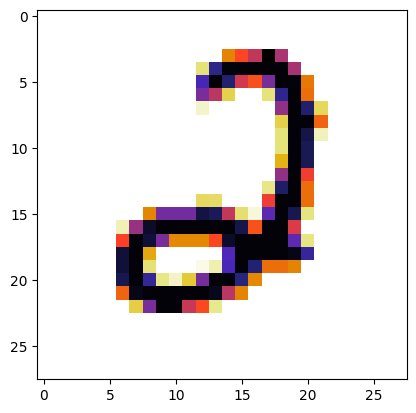

In [174]:
y_predict=logits.argmax(1)
# ypredict
plt.imshow(img.cpu().squeeze(), cmap='CMRmap_r');
print(f'logits:{logits}')
print(f'predicted category: {y_predict[0]}')
print(f'actual category: {lbl[0]}')

In [176]:
#Back propagation:
fn_loss=nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.3) #gradient descending, learning rate of 30%
loss=fn_loss(logits, lbl)
loss

tensor(1.6265, grad_fn=<NllLossBackward0>)

In [177]:
#now lets calculate de gradients of the loss i.e (calculate the change of the loss regarding to model parameters)
loss.backward()
optimizer.step()
optimizer.zero_grad()    

In [222]:
from torch.utils.data import DataLoader
batchsize=2000

train_loader=DataLoader(
    dataset=train, 
    batch_size=batchsize, 
    shuffle=True
)

val_loader=DataLoader(
    dataset=val,
    batch_size=batchsize,
    shuffle=False
)

In [223]:
#training yn validation of the model
#lets take our forward and back propagation and set it in a loop for to iterate it
#hiperparameters...
learning_rate=0.1
epochs=10 #"the epoch the number of time we want to execute forward-backward"
#lets build our loss function
fn_loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)

In [226]:
#the best practice is to generate two principal funcions : one to train and one more for the validatoin then set them into the 10 for loop 
def train_loop(dataloader, model, loss_fn, optimizer):
    train_size=len(dataloader.dataset)
    nbatches=len(dataloader)

    model.train()

    loss_accum, accuracy_accum= 0, 0

    for nbatch, (X, y) in enumerate(dataloader):
        X, y=X.to(device), y.to(device)
        logits=model(X)
        loss=fn_loss(logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_train += loss.item()
        accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()
        if nbatch %10==0:
            ndata = nbatch*batchsize
            print(f'\tloss:{loss.item():>7f} [{ndata:>5d}/{train_size:>5d}]')

loss_train /= nbatches
accuracy /= train_size
print(f'\Accuracy/loss (avg)')
print(f'\t\tAccuracy/losss (average) {(100*accuracy):>0.1f}%/{loss_train:>8f}')

NameError: name 'loss_train' is not defined

In [227]:
def val_loop(dataloader, model, fn_loss):
    val_size=len(dataloader.dataset)
    nbatches=len(dataloader)
    model.eval()
    loss_val, accuracy= 0,0

    with torch.no_grad():

        for X,y in dataloader:
            X, y=X.to(device)
            logits=model(X)

            loss_val +=fn_loss(logits, y).item()
            exactitud +=(logits.argmax(1)==y).type(torch.float).sum().item()

loss_val /= nbatches
accuracy /= val_size

# print(f'\Accuracy/loss (avg)')
print(f'\t\tAccuracy/losss (average) {(100*accuracy):>0.1f}%/{loss_val:>8f}')

NameError: name 'loss_val' is not defined

In [228]:
for t in range(epochs):
    print(f'iteracion{t+1}/{epochs}\n----------------')
    train_loop(train_loader, model, fn_loss, optimizer)
    val_loop(val_loader, model, fn_loss)
print('eso!')

iteracion1/10
----------------


c:\Users\ARMANDO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


IndexError: Target 8 is out of bounds.